In [1]:
import duckdb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import yellowbrick
import folium 
import seaborn as sns   

# UTMB races notebook 
## Roadmap: 
1. EDA (quick and dirty look at the data to understand it)
2. map with all the locations of the races with:
    - the distances offered 
    - the dates 
    - the styles 
3. Cluster analysis to see what races are similar to each other 
    --> Maybe use this to make a recommendation system for people where people can input their preferences such as time of year, distances, style, etc.
4. add a layer for explainability to the cluster analysis and the recommendation system. 
5. (optional) Maybe make a second DAG to go into each race and retrieve more data. 

In [2]:
#load the data from duckdb
conn = duckdb.connect('../data/utmb_db.duckdb')
table  = conn.sql("select * from UTMB").df()
print(table)

                                   name  date_confirmed              country  \
0                     Nice Côte d'Azur             True               France   
1     Tarawera Ultra-Trail New Zealand             True          New Zealand   
2              Amazean Jungle Thailand            False             Thailand   
3                    Valhöll Argentina             True            Argentina   
4                  Chianti Ultra Trail             True                Italy   
5   Desert Rats Trail Running Festival            False        United States   
6                           Istria 100             True              Croatia   
7                Ultra-Trail Mount Yun             True                China   
8                   Grand Raid Ventoux             True               France   
9               Canyons Endurance Runs             True        United States   
10              Quindío Trail Colombia             True             Colombia   
11               Ultra-Trail Australia  

In [3]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        50 non-null     object 
 1   date_confirmed              50 non-null     bool   
 2   country                     50 non-null     object 
 3   city                        50 non-null     object 
 4   image                       50 non-null     object 
 5   link                        50 non-null     object 
 6   distance_5                  50 non-null     bool   
 7   distance_10                 50 non-null     bool   
 8   distance_15                 50 non-null     bool   
 9   distance_20                 50 non-null     bool   
 10  distance_25                 50 non-null     bool   
 11  distance_30                 50 non-null     bool   
 12  distance_35                 50 non-null     bool   
 13  distance_40                 50 non-nu

In [4]:
table.describe()

,start_day,end_day,month,year,duration,latitude,longitude
count,27.000000,27.000000,50.000000,50.000000,27.000000,50.000000,50.000000
mean,15.296296,17.370370,6.980000,2025.020000,2.185185,28.755822,3.224303
std,7.415238,7.535292,2.729207,0.141421,1.545142,26.979241,81.260921
min,2.000000,4.000000,1.000000,2025.000000,1.000000,-38.138149,-179.283333
25%,11.000000,13.000000,5.000000,2025.000000,1.500000,23.494097,-54.962090
50%,16.000000,18.000000,7.000000,2025.000000,2.000000,41.628905,7.294028
75%,21.000000,22.000000,9.000000,2025.000000,2.000000,46.446471,34.272637
max,26.000000,29.000000,12.000000,2026.000000,9.000000,56.426789,176.252922


## Dashboard:
- A dashboard with basic information regarding the UTMB World Series events.  
- A map with all the locations of the events.


In [5]:
number_of_events =table.shape[0]
number_of_countries = table['country'].nunique()
number_of_cities = table['city'].nunique()

print(f'Over the year there are {number_of_events} events in {number_of_cities} cities from {number_of_countries} different countries.')


Over the year there are 50 events in 50 cities from 29 different countries.


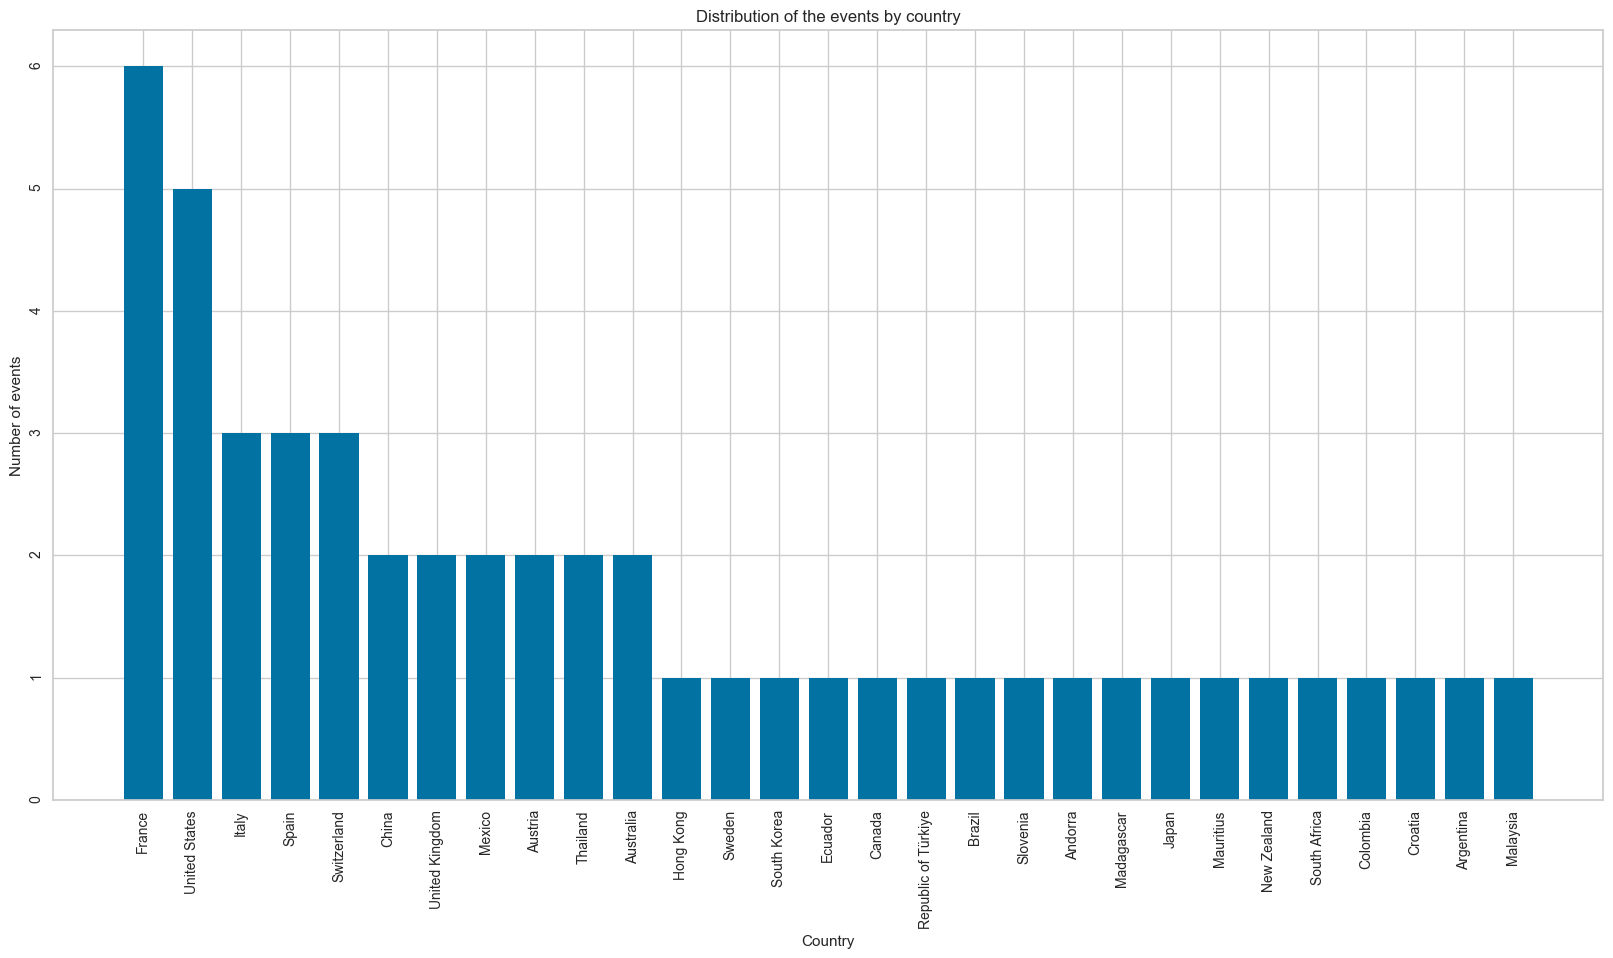

In [6]:
#distribution of the events by country
country_distribution = table['country'].value_counts()
country_distribution
fig =plt.figure(figsize=(20,10))
plt.bar(country_distribution.index, country_distribution.values)
fig.axes[0].tick_params(labelrotation=90)
fig.axes[0].set_title('Distribution of the events by country')
fig.axes[0].set_xlabel('Country')
fig.axes[0].set_ylabel('Number of events')
plt.show()

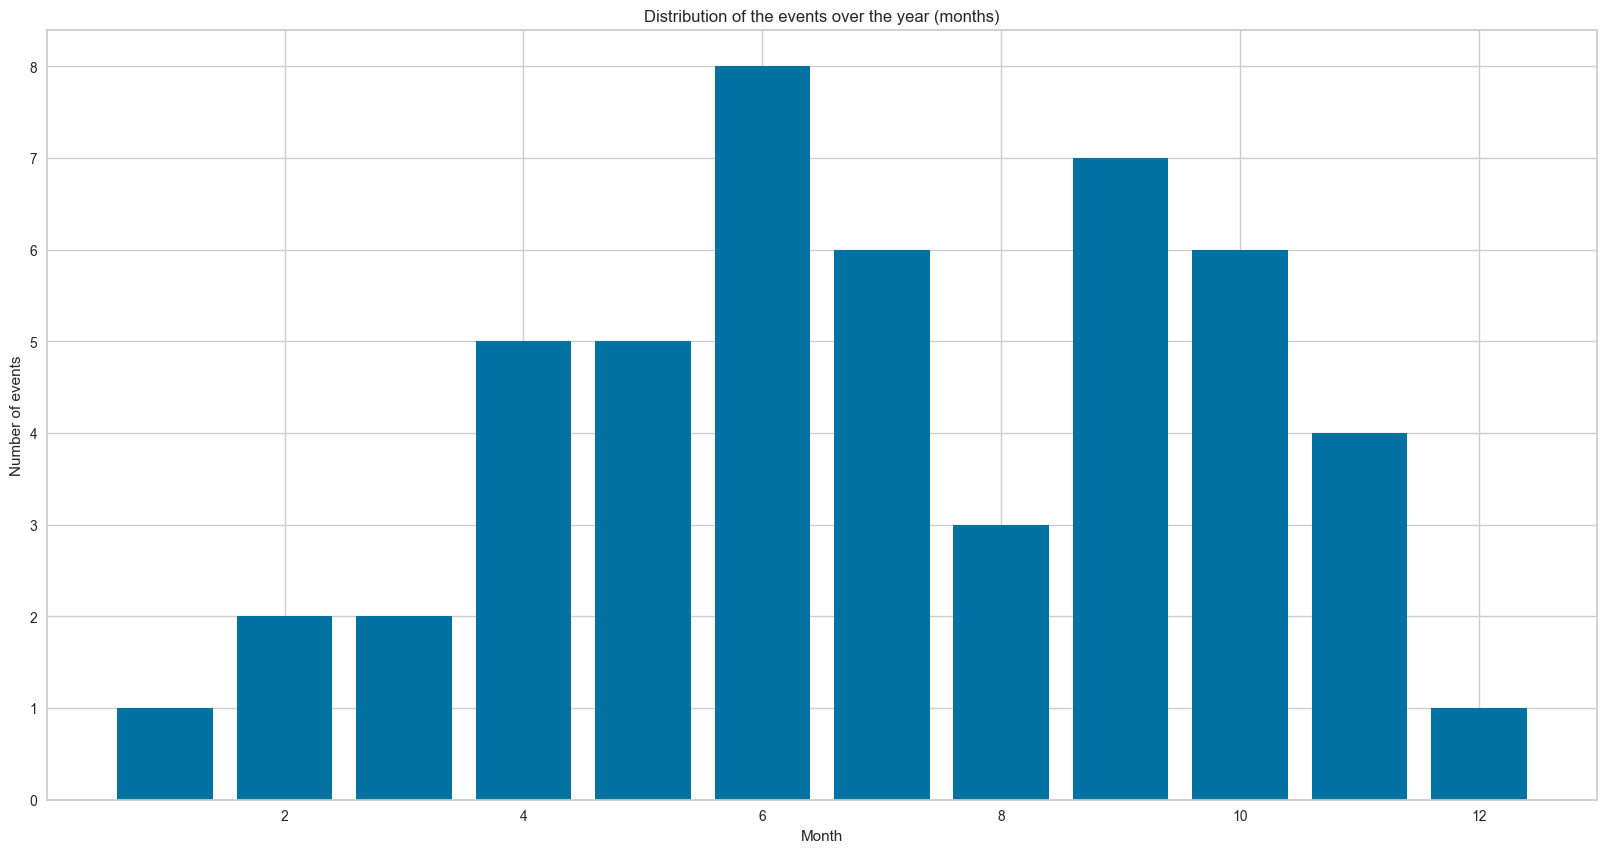

In [7]:
#distribution of the events over the year (months)
month_distribution = table['month'].value_counts()
fig =plt.figure(figsize=(20,10))	
plt.bar(month_distribution.index, month_distribution.values)
fig.axes[0].set_title('Distribution of the events over the year (months)')
fig.axes[0].set_xlabel('Month')
fig.axes[0].set_ylabel('Number of events')
plt.show()

In [8]:
# start_day as int 
table['start_day'] = table['start_day'].replace(np.nan, 0)
table['start_day'] = table['start_day'].astype(int)
#month as int
table['month'] = table['month'].astype(int)
#year as int
table['year'] = table['year'].astype(int)
#end_day as int
table['end_day'] = table['end_day'].replace(np.nan, 0)
table['end_day'] = table['end_day'].astype(int)
#duration remove nan
table['duration'] = table['duration'].replace(np.nan, 0)
#mutli_day if unknown then False
table['multidays'] = table['multidays'].replace(np.nan, False)

/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_33219/814475611.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  table['multidays'] = table['multidays'].replace(np.nan, False)


In [9]:
# Function to retrieve offered distances for a row
def get_offered_distances(row):
    # Filter columns that start with 'distance_'
    distance_columns = [col for col in row.index if col.startswith('distance_')]
    
    # Extract distances where the flag is True
    offered_distances = [col.replace('distance_', '') for col in distance_columns if row[col]]
    
    # Join the distances into a comma-separated string
    return ', '.join(offered_distances)

In [10]:
import wordninja
def split_into_words_wordninja(input_string):
    replacements = {
        'S': 'Sand',
        'U': 'UTMB'
    }
    remove = ['and','TMB' ]
    # Use wordninja to split the string
    words = wordninja.split(input_string)
    words = [replacements.get(word, word) for word in words]
    words = [word for word in words if word not in remove]
    return ' '.join(words)


In [11]:
import wordninja
# Function to retrieve offered distances for a row
def get_offered_styles(row):
    # Filter columns that start with 'style_'
    style_columns = [col for col in row.index if col.startswith('style_')]
    
    # Extract distances where the flag is True
    offered_styles = [col.replace('style_', '') for col in style_columns if row[col]]
    offered_styles = [split_into_words_wordninja(style) for style in offered_styles]
    # Join the distances into a comma-separated string
    return ', '.join(offered_styles)

In [12]:
from datetime import datetime, timedelta
s = folium.Map(location=[table['latitude'].mean(), table['longitude'].mean()], zoom_start=2)
for i in range(table.shape[0]):
    offered_distances = get_offered_distances(table.iloc[i])
    offered_styles = get_offered_styles(table.iloc[i])
    name = table['name'][i]
    image = table['image'][i]
    country = table['country'][i]
    city = table['city'][i]
    style = get_offered_styles(table.iloc[i])
    if table['start_day'][i] != 0:
        start_date = datetime(table['year'][i], table['month'][i], table['start_day'][i]).strftime('%Y-%m-%d')
    else:
        start_date = datetime(table['year'][i], table['month'][i],1).strftime('%Y-%m')
        start_date+=' day to be defined'
    if table['multidays'][i]:
        duration = table['duration'][i]
        if table['end_day'][i] != 0:
            end_date= datetime(table['year'][i], table['month'][i], table['end_day'][i]).strftime('%Y-%m-%d')
        else:
            pass
        dates_str=f'<p style="margin: 0; font-size: 14px; color: #555;"><strong>Dates:</strong> From {start_date} to {end_date} ({int(duration)} days)</p'
    else:
        dates_str=f'<p style="margin: 0; font-size: 14px; color: #555;"><strong>Date:</strong> {start_date}</p>'

    html = f"""
    <div style="font-family: Arial, sans-serif; width: 400px;">
        <h3 style="margin: 0; padding: 0; font-size: 18px; color: #333;">{name}</h3>
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ccc;">
        <img src="{image}" alt="image" style="width: 60%; height: auto; border-radius: 5px; margin-bottom: 10px;">
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Distances:</strong> {offered_distances} km</p>
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Type of race:</strong> {offered_styles}</p> 
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Location:</strong> {city} ({country})</p> 
        {dates_str}
    </div>
    """ 
    folium.Marker([table['latitude'][i], table['longitude'][i]], popup=html,color='red').add_to(s)

In [13]:
s

## Cluster analysis 
- K-means clustering

In [14]:
table.columns

Index(['name', 'date_confirmed', 'country', 'city', 'image', 'link',
       'distance_5', 'distance_10', 'distance_15', 'distance_20',
       'distance_25', 'distance_30', 'distance_35', 'distance_40',
       'distance_45', 'distance_50', 'distance_55', 'distance_60',
       'distance_65', 'distance_70', 'distance_75', 'distance_80',
       'distance_85', 'distance_90', 'distance_95', 'distance_100',
       'distance_105', 'distance_110', 'distance_115', 'distance_120',
       'distance_125', 'distance_130', 'distance_135', 'distance_140',
       'distance_145', 'distance_150', 'distance_155', 'distance_160',
       'distance_165', 'distance_170', 'distance_175', 'distance_250',
       'distance_300', 'style_', 'style_Altitude', 'style_Asateam',
       'style_Autonomy', 'style_Capitals/largecities', 'style_Cascade',
       'style_Castles', 'style_Children's&Juniors', 'style_CitytoCity',
       'style_Cliffs', 'style_Cross-border', 'style_Culture&History',
       'style_Duo', 'style_For

Variables to remove:
1. self explenatory ones:
    - name, image, link, date_confirmed
2. start and end date are not needed as we have the duration and a number is not very indicative
3. city, as it would create too many dummies and country should be enough 
4. country, as we have the location and the location is more specific
6. style_UTMBWorldSeries as all races are part of the UTMB World Series

In [15]:
X_cluster = table.drop(['name','country','city','image','link','date_confirmed','start_day','end_day','style_UTMBWorldSeries'],axis=1)

In [16]:
#X_cluster = X_cluster.drop('cluster',axis=1)

In [17]:
from sklearn.preprocessing import StandardScaler
numeric_columns = X_cluster.select_dtypes('number').columns
numeric_columns = numeric_columns.drop(['latitude','longitude'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster[numeric_columns])



In [18]:
X_cluster = X_cluster.drop(numeric_columns, axis=1)
X_cluster = pd.concat([X_cluster, pd.DataFrame(X_scaled, columns=numeric_columns)], axis=1)

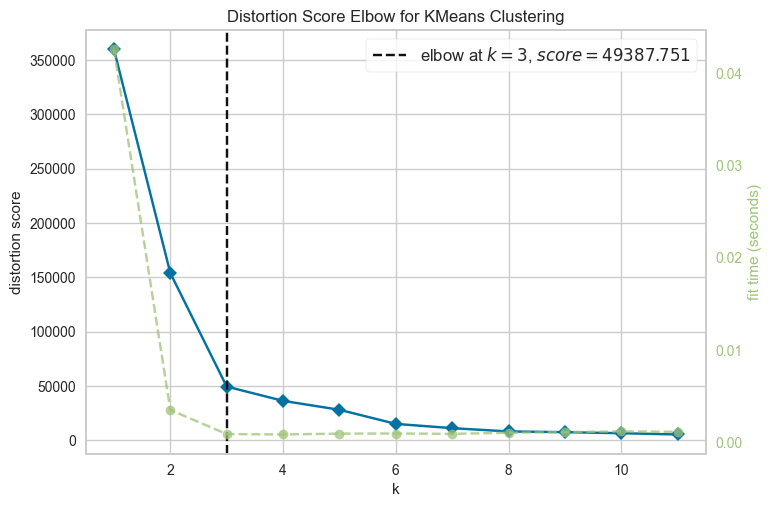

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X_cluster)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [20]:
k = visualizer.elbow_value_
kmeans = KMeans(n_clusters=k)

In [21]:
kmeans.fit_predict(X_cluster)

array([2, 0, 0, 1, 2, 1, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 0, 2, 2,
       1, 0, 0, 0, 0, 2], dtype=int32)

/Users/thibtd/some fun/utmb_data_eng/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


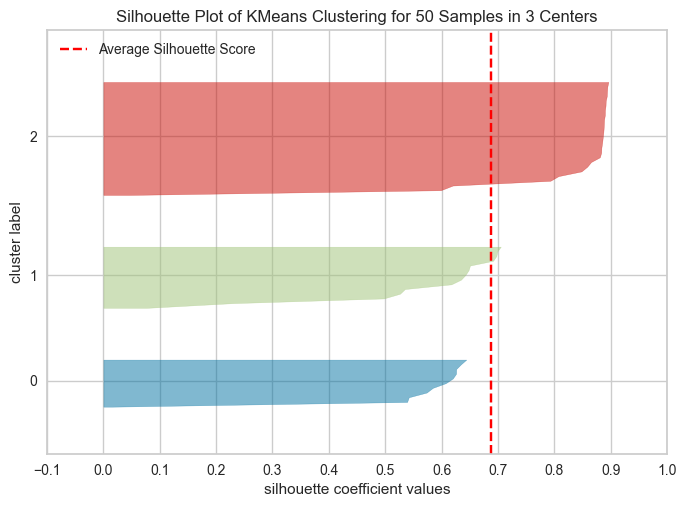

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 50 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_cluster)
visualizer.show()

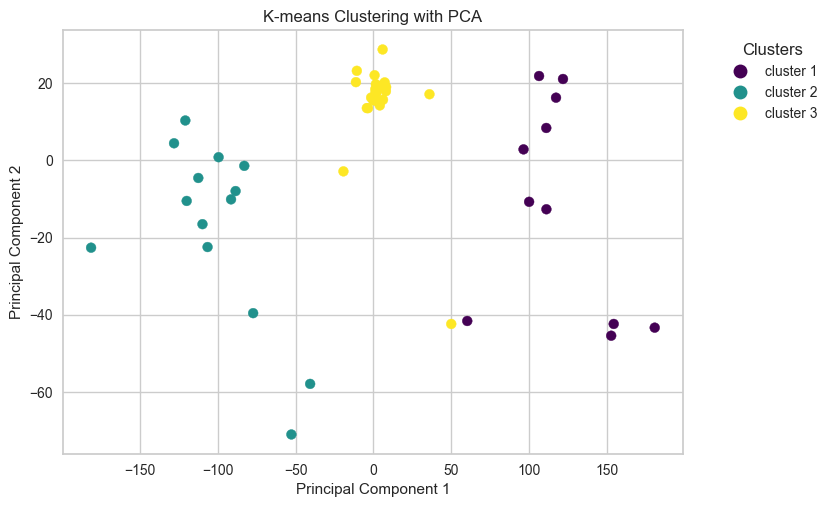

In [23]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

cluster_names = ['cluster 1','cluster 2','cluster 3']
# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=cluster_names[i], 
           markerfacecolor=plt.cm.viridis(i / (len(cluster_names) - 1)), markersize=10)
    for i in range(len(cluster_names))
]
# Add legend
plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [24]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio per Component:", explained_variance_ratio)

# Cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_explained_variance)

Explained Variance Ratio per Component: [0.91427191 0.08455765]
Cumulative Explained Variance: [0.91427191 0.99882956]


In [25]:
# PCA components (loadings)
components = pca.components_

In [26]:
# Rank features by importance for each component
for i, component in enumerate(abs(components)):
    ranked_features = pd.Series(component, index=X_cluster.columns).sort_values(ascending=False)
    print(f"Top Features for PC{i+1}:\n", ranked_features.head(5))

Top Features for PC1:
 longitude        0.991135
latitude         0.132808
style_Cascade    0.001017
duration         0.000997
distance_10      0.000977
dtype: float64
Top Features for PC2:
 latitude     0.990978
longitude    0.132774
duration     0.011534
year         0.004753
multidays    0.004701
dtype: float64


In [27]:
X_cluster

,distance_5,distance_10,distance_15,distance_20,distance_25,distance_30,distance_35,distance_40,distance_45,distance_50,...,style_Vineyard,discipline_Road Running,discipline_Trail,discipline_Walking,multidays,latitude,longitude,month,year,duration
0,False,False,False,True,False,False,False,False,False,False,...,False,False,True,False,True,43.700936,7.268391,0.747656,-0.142857,0.526290
1,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,-38.138149,176.252922,-1.843231,-0.142857,-0.115527
2,False,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,1.479729,111.474787,-1.843231,-0.142857,-0.757344
3,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,-34.612958,-58.377647,-1.473104,-0.142857,-0.115527
4,False,True,False,True,False,False,False,False,True,False,...,True,False,True,False,True,43.487052,11.374700,-1.473104,-0.142857,0.526290
5,False,True,False,True,False,False,False,False,False,True,...,False,False,True,False,False,39.158870,-108.728988,-1.102978,-0.142857,-0.757344
6,False,False,False,True,False,False,False,True,False,False,...,False,False,True,False,True,45.432359,13.522410,-1.102978,-0.142857,0.526290
7,False,True,False,True,False,True,False,False,False,True,...,False,False,True,False,True,36.229963,111.381767,-1.102978,-0.142857,5.019011
8,False,False,False,False,True,False,False,False,True,False,...,False,False,True,False,True,44.173274,5.132126,-1.102978,-0.142857,0.526290
9,False,False,False,False,True,False,False,False,False,True,...,False,False,True,False,True,32.609857,-85.480783,-1.102978,-0.142857,-0.115527


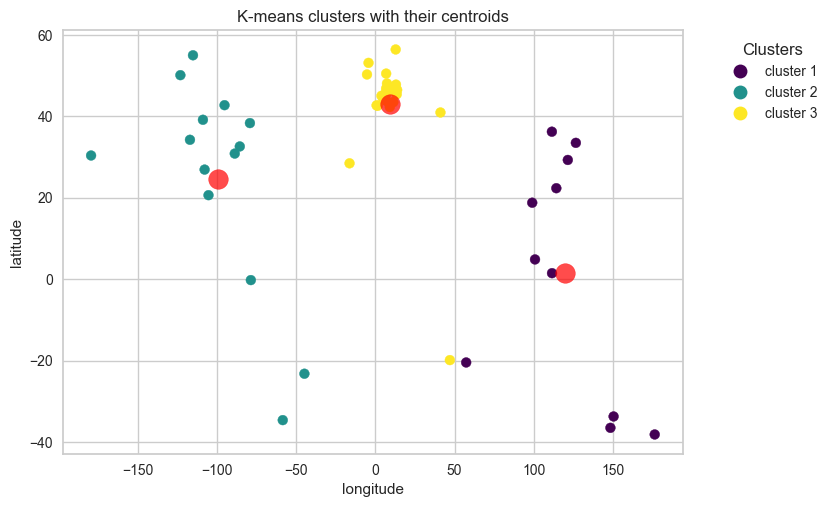

In [28]:
cluster_names = ['cluster 1','cluster 2','cluster 3']
plt.scatter(X_cluster['longitude'],X_cluster['latitude'], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, -4], kmeans.cluster_centers_[:, -5], c='red', s=200, alpha=0.7)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=cluster_names[i], 
           markerfacecolor=plt.cm.viridis(i / (len(cluster_names) - 1)), markersize=10)
    for i in range(len(cluster_names))
]
# Add legend
plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-means clusters with their centroids')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [29]:
map_cluster = folium.Map(location=[table['latitude'].mean(), table['longitude'].mean()], zoom_start=2)


In [30]:
center_lat = kmeans.cluster_centers_[:, -5]
center_lon = kmeans.cluster_centers_[:, -4]
table['cluster']= kmeans.labels_
colors = ['red','blue','green']
groups = {}
for i in range(k):
    groups[f'cluster_{i}'] = folium.FeatureGroup(name=f'Cluster {i}').add_to(map_cluster)
    folium.CircleMarker(
    location=[center_lat[i],center_lon[i]],
    radius=25,
    fill=True,
    color=colors[i],
    popup=folium.Popup(f"center of cluster {i+1} "),
).add_to(map_cluster)


In [31]:
for i in range(table.shape[0]):
    offered_distances = get_offered_distances(table.iloc[i])
    offered_styles = get_offered_styles(table.iloc[i])
    name = table['name'][i]
    image = table['image'][i]
    country = table['country'][i]
    city = table['city'][i]
    cluster = table['cluster'][i]
    style = get_offered_styles(table.iloc[i])
    if table['start_day'][i] != 0:
        start_date = datetime(table['year'][i], table['month'][i], table['start_day'][i]).strftime('%Y-%m-%d')
    else:
        start_date = datetime(table['year'][i], table['month'][i],1).strftime('%Y-%m')
        start_date+=' day to be defined'
    if table['multidays'][i]:
        duration = table['duration'][i]
        if table['end_day'][i] != 0:
            end_date= datetime(table['year'][i], table['month'][i], table['end_day'][i]).strftime('%Y-%m-%d')
        else:
            pass
        dates_str=f'<p style="margin: 0; font-size: 14px; color: #555;"><strong>Dates:</strong> From {start_date} to {end_date} ({int(duration)} days)</p'
    else:
        dates_str=f'<p style="margin: 0; font-size: 14px; color: #555;"><strong>Date:</strong> {start_date}</p>'

    html = f"""
    <div style="font-family: Arial, sans-serif; width: 400px;">
        <h3 style="margin: 0; padding: 0; font-size: 18px; color: #333;">{name}</h3>
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ccc;">
        <img src="{image}" alt="image" style="width: 60%; height: auto; border-radius: 5px; margin-bottom: 10px;">
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Distances:</strong> {offered_distances} km</p>
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Type of race:</strong> {offered_styles}</p> 
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Location:</strong> {city} ({country})</p> 
        {dates_str}
    </div>
    """ 
    folium.Marker([table['latitude'][i], table['longitude'][i]], popup=html,icon=folium.Icon(color=colors[cluster])).add_to(groups[f'cluster_{cluster}'])



In [32]:
map_cluster

## Recommender system using the k-means clustering

In [33]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add plugins-utils to sys.path
sys.path.append(os.path.join(root_dir, "plugins"))
from sklearn.preprocessing import MultiLabelBinarizer
from utils import get_lat_long, round_to_nearest_5

def get_user_preference(preferences:dict, data:pd.DataFrame,scaler:StandardScaler)->pd.DataFrame:
    
    min_dist, max_dist = preferences['distance']
    distance_list = [round_to_nearest_5(i) for i in range(min_dist, max_dist+1,5)]
    if 0 in distance_list:
        distance_list.remove(0)
        
    preferences['distance'] = distance_list
    # Convert list-type values into a flat dictionary
    flattened_prefs = {
        f"{key}_{value}": True for key, values in preferences.items() if isinstance(values, list) for value in values
    }

    # Include non-list values as they are except country
    flattened_prefs.update({key: value for key, value in preferences.items() if key !='country' and  not isinstance(value, list)})
    print(flattened_prefs)

    # Replace 'country' with latitude and longitude
    lat, lon = get_lat_long(preferences['country'])
    flattened_prefs["latitude"] = lat
    flattened_prefs["longitude"] = lon

    user_pref = pd.DataFrame(data = flattened_prefs, columns=data.columns,index=[0])
    user_pref['year'] = user_pref['year'].astype(int)
    cat_columns = data.select_dtypes(include=['bool']).columns
    numeric_columns = data.select_dtypes(include=['number']).columns
    print(numeric_columns)
    user_pref[cat_columns] = user_pref[cat_columns].fillna(False).astype(bool)
    user_pref[numeric_columns] = user_pref[numeric_columns].fillna(0).astype(int)
    numeric_columns = numeric_columns.drop(['latitude','longitude'])
    print(numeric_columns)
    X_scaled = scaler.transform(user_pref[numeric_columns])
    user_pref = user_pref.drop(numeric_columns, axis=1)
    user_pref = pd.concat([user_pref, pd.DataFrame(X_scaled, columns=numeric_columns)], axis=1)
    return user_pref

In [34]:
preferences = {
    'distance':[20,80],
    'style':["Mountain","Forest",'Stages'],
    'month':6,
    "year":2025,
    'country':"Austria",
    'multidays':True,
    'discipline':['Trail']
}
user_pref = get_user_preference(preferences=preferences,data=X_cluster,scaler=scaler)
user_pref

{'distance_20': True, 'distance_25': True, 'distance_30': True, 'distance_35': True, 'distance_40': True, 'distance_45': True, 'distance_50': True, 'distance_55': True, 'distance_60': True, 'distance_65': True, 'distance_70': True, 'distance_75': True, 'distance_80': True, 'style_Mountain': True, 'style_Forest': True, 'style_Stages': True, 'discipline_Trail': True, 'month': 6, 'year': 2025, 'multidays': True}
Index(['latitude', 'longitude', 'month', 'year', 'duration'], dtype='object')
Index(['month', 'year', 'duration'], dtype='object')


/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_33219/3190066565.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_pref[cat_columns] = user_pref[cat_columns].fillna(False).astype(bool)
/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_33219/3190066565.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_pref[numeric_columns] = user_pref[numeric_columns].fillna(0).astype(int)


,distance_5,distance_10,distance_15,distance_20,distance_25,distance_30,distance_35,distance_40,distance_45,distance_50,...,style_Vineyard,discipline_Road Running,discipline_Trail,discipline_Walking,multidays,latitude,longitude,month,year,duration
0,False,False,False,True,True,True,True,True,True,True,...,False,False,True,False,True,47,14,-0.362724,-0.142857,-0.757344


In [35]:
distances = kmeans.predict(user_pref)
closest_cluster = np.argmin(distances)
X_cluster['cluster'] = kmeans.labels_
# Recommend races from the closest cluster
recommended_races = X_cluster[X_cluster['cluster'] == closest_cluster]

# Display recommendations
#print(recommended_races[['name', 'cluster']])
recommended_races

,distance_5,distance_10,distance_15,distance_20,distance_25,distance_30,distance_35,distance_40,distance_45,distance_50,...,discipline_Road Running,discipline_Trail,discipline_Walking,multidays,latitude,longitude,month,year,duration,cluster
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,-38.138149,176.252922,-1.843231,-0.142857,-0.115527,0
2,False,False,True,False,False,True,False,False,False,False,...,False,True,False,False,1.479729,111.474787,-1.843231,-0.142857,-0.757344,0
7,False,True,False,True,False,True,False,False,False,True,...,False,True,False,True,36.229963,111.381767,-1.102978,-0.142857,5.019011,0
11,False,True,False,True,False,False,False,False,False,True,...,False,True,False,True,-33.713759,150.312163,-0.732851,-0.142857,0.526290,0
19,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,-20.454075,57.321302,-0.362724,-0.142857,-0.757344,0
40,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,33.493838,126.502462,1.117783,-0.142857,-0.757344,0
41,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,29.290777,121.425225,1.117783,-0.142857,-0.757344,0
45,False,False,False,False,True,False,False,False,False,True,...,False,True,False,False,22.350627,114.184916,1.487910,-0.142857,-0.757344,0
46,True,False,True,False,True,False,False,False,False,True,...,False,True,False,False,4.854677,100.743883,1.487910,-0.142857,-0.757344,0
47,False,False,False,False,False,True,False,False,False,True,...,False,True,False,False,-36.504775,148.305709,1.487910,-0.142857,-0.757344,0


In [36]:
recommended_races.drop('cluster',axis=1,inplace=True)

/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_33219/874514878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_races.drop('cluster',axis=1,inplace=True)


In [37]:
from sklearn.metrics.pairwise import cosine_similarity


cosine_sim = cosine_similarity(user_pref,recommended_races)
# Rank races by similarity
recommended_races['similarity'] = cosine_sim[0]
recommendations = recommended_races.sort_values(by='similarity', ascending=False).head(5)

/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_33219/2082865309.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_races['similarity'] = cosine_sim[0]


In [38]:
recommendations = table.loc[recommendations.index]
recommendations

,name,date_confirmed,country,city,image,link,distance_5,distance_10,distance_15,distance_20,...,discipline_Walking,multidays,start_day,end_day,month,year,duration,latitude,longitude,cluster
7,Ultra-Trail Mount Yun,True,China,Linfen,https://res.cloudinary.com/kavval/image/upload...,https://www.finishers.com/en/event/ultra-trail...,False,True,False,True,...,False,True,11,20,4,2025,9.0,36.229963,111.381767,0
40,TransJeju,False,South Korea,Jeju City,https://res.cloudinary.com/kavval/image/upload...,https://www.finishers.com/en/event/transjeju-b...,False,False,False,True,...,False,False,0,0,10,2025,0.0,33.493838,126.502462,0
41,Ultra-Trail Ninghai,False,China,Ninghai,https://res.cloudinary.com/kavval/image/upload...,https://www.finishers.com/en/event/ultra-trail...,False,False,False,False,...,False,False,0,0,10,2025,0.0,29.290777,121.425225,0
45,TransLantau,False,Hong Kong,Hong-Kong,https://res.cloudinary.com/kavval/image/upload...,https://www.finishers.com/en/event/translantau...,False,False,False,False,...,False,False,0,0,11,2025,0.0,22.350627,114.184916,0
48,Hoka Chiang Mai Thaïland,False,Thailand,Chiang Mai,https://res.cloudinary.com/kavval/image/upload...,https://www.finishers.com/en/event/hoka-chiang...,False,True,False,False,...,False,False,0,0,12,2025,0.0,18.788278,98.985880,0


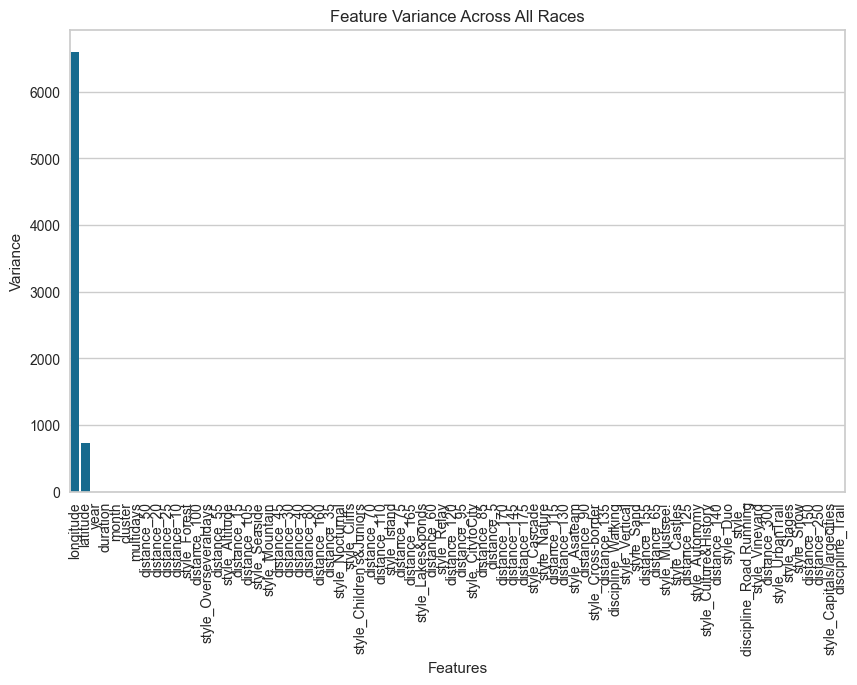

In [39]:
# Calculate the variance of each feature across all races
feature_variance = X_cluster.var()

# Sort the features by variance
feature_variance_sorted = feature_variance.sort_values(ascending=False)

# Plot the variance of features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_variance_sorted.index, y=feature_variance_sorted.values)
plt.title('Feature Variance Across All Races')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

In [40]:
# Calculate the correlation between each feature and the similarity score
# Remove constant columns
correlation_with_similarity = recommended_races.corr()['similarity'].sort_values(ascending=False)
print(correlation_with_similarity)
correlation_with_similarity.drop('similarity', inplace=True)
correlation_with_similarity.dropna(inplace=True)
# Plot the correlation
fig = px.bar(
    x=correlation_with_similarity.index,
    y=correlation_with_similarity.values,
    labels={'x': 'Features', 'y': 'Correlation with Similarity'},
    title='Correlation of Features with Cosine Similarity Score'
)

# Show the plot
fig.show()

similarity                 1.000000
latitude                   0.955606
style_Overseveraldays      0.439909
distance_70                0.396305
distance_160               0.396305
                             ...   
style_Vineyard                  NaN
discipline_Road Running         NaN
discipline_Trail                NaN
discipline_Walking              NaN
year                            NaN
Name: similarity, Length: 76, dtype: float64
